In [2]:
import pandas as pd
import json
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import QED, AllChem
from rdkit.Chem.Descriptors import ExactMolWt
from scipy.stats import pearsonr
from copy import deepcopy

from tqdm import tqdm
tqdm.pandas()

## Split data into training and test sets

In [ ]:
data = pd.read_csv("zinc250k.csv")

for protein in ['parp1', 'fa7', '5ht1b', 'braf', 'jak2']:
    y = np.clip(data[protein], 0., 20.) / 20.0
    y *= data['qed']
    y *= data['sa']
    
    # get larger half as test set
    test_idx = y[y > y.median()].index.to_list()
    with open(os.path.join(f'valid_idx_zinc250k_{protein}.json'), "w") as f:
        json.dump(test_idx, f)

## Compare property distributions of training data and context set

In [8]:
training_data = pd.read_csv("zinc250k.csv").sample(n=10_000, random_state=0)
context_data = pd.read_csv("zinc500k.csv").sample(n=10_000, random_state=0)


df = pd.concat([
    pd.DataFrame({"smiles": training_data["smiles"], "Dataset": "labeled dataset"}),
    pd.DataFrame({"smiles": context_data["smiles"], "Dataset": "unlabeled context points"}),
])

df = df.dropna()
df["Dataset"].value_counts()

Dataset
labeled dataset             10000
unlabeled context points    10000
Name: count, dtype: int64

In [9]:
# derive molecular properties and also add number of heavy atoms
df["mol"] = df["smiles"].progress_apply(AllChem.MolFromSmiles)

props = df.progress_apply(lambda x: QED.properties(x['mol'])._asdict(), axis=1, result_type='expand')
df = df.join(props)
mol_props = props.columns.to_list()
mol_props.remove('ALERTS')
df["num_atoms"] = df["mol"].apply(lambda x: x.GetNumHeavyAtoms())
mol_props.append("num_atoms")

100%|██████████████████████████████████████████| 20000/20000 [00:24<00:00, 805.79it/s]


In [10]:
mol_prop_map={
    "MW": "molecular weight", "num_atoms": "number of atoms", 
    'HBA': "number of H-bond acceptors","ALOGP": "lipophilicity", 'HBD': "number of H-bond donors", 'ROTB': "number of rotable bonds", 
    'AROM': "number of aromatic rings", "PSA": "polarizable surface area",
}

for c in df.columns:
    if c in mol_prop_map and "number" in mol_prop_map[c]:
        df[c] = df[c].astype(int)

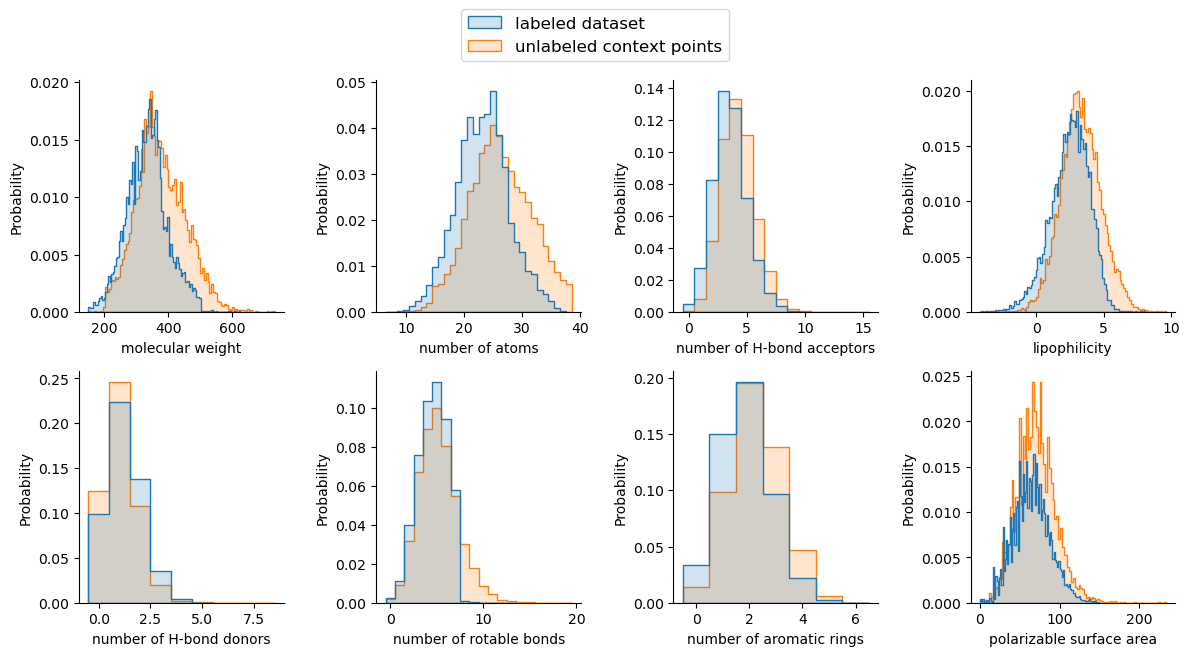

In [11]:
plot_df = pd.melt(
    frame=df,
    id_vars=["Dataset"],
    value_vars=mol_props,
    var_name='property'
)

fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=4)

for i, mol_prop in enumerate(mol_prop_map.keys()):
    
    is_discrete = "number" in mol_prop_map[mol_prop]
    
    g = sns.histplot(
        data=df, x=mol_prop, hue="Dataset", common_norm=True, common_bins=False,
        stat='probability', ax=axs[i//4, i%4],
        discrete=is_discrete, element="step",
        alpha=0.2, bins=100 if not is_discrete else "auto"
    )
    axs[i//4, i%4].set_xlabel(mol_prop_map[mol_prop])
    #axs[i//4, i%4].get_legend().remove()
    #if i == 2:
    #    axs[i//3, i%3].get_legend().remove()

    
handles = axs[0,0].get_legend().legend_handles
labels = [l.get_text() for l in list(axs[0,0].get_legend().get_texts())]
# Get the handles and labels from any one of the subplots
#handles, labels = axs[0, 0].get_legend_handles_labels()

for i in range(8):
    axs[i//4, i%4].get_legend().remove()

# Create a single legend for the figure
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize="large",)

sns.despine()
plt.tight_layout()